# Analyzing the Democratic Debates of 2020

The following exercise involves some exploratory data analysis, and topic modeling in order to identify congressmen/congresswomen-level statistics, and the topics that they tend to speak about.

In [75]:
# Importing the essential libraries for the exercise.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Linking the directory to access the dataset.
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/democratic-debate-transcripts-2020/debate_transcripts_v2_2020-02-23.csv


In [2]:
# Reading the data, and exploring its characteristics.
path = "../input/democratic-debate-transcripts-2020/debate_transcripts_v2_2020-02-23.csv"
data = pd.read_csv(path, encoding = "ISO-8859-1")
data[0:5]

,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didnt miss anything. Its a long rac...",36.0
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0


## Exploratory Data Analysis

In [3]:
# Dictionary of the debates.
debate_names = data["debate_name"]
number_of_debates = len(set(debate_names))
print("Total number of democratic debates:", number_of_debates, "debates")

# Dictionary of number of sections.
debate_section = data["debate_section"]
number_of_sections = len(set(debate_section))
print("Maximum number of sections in the debates:", number_of_sections, "sections")

# Dictionary of name of speakers.
dem_speakers = data["speaker"]
number_of_speakers = len(set(dem_speakers))
print("Total number of democratic speakers:",number_of_speakers, "speakers")

# Mean duration of speech.
print("The average speaking time is:",np.mean(data["speaking_time_seconds"]), "seconds")

Total number of democratic debates: 11 debates
Maximum number of sections in the debates: 17 sections
Total number of democratic speakers: 101 speakers
The average speaking time is: 17.0448132780083 seconds


In [4]:
# Sorted dictionary of debates.
debs = dict()
for i in debate_names:
    debs[i] = debs.get(i, 0) + 1

debates = {k: v for k, v in sorted(debs.items(), key=lambda item: item[1])}
 
# Sorted dictionary of sections.
secs = dict()
for i in debate_section:
    secs[i] = secs.get(i, 0) + 1

sections = {k: v for k, v in sorted(secs.items(), key=lambda item: item[1])}

# Sorted dictionary of speakers.
spkrs = dict()
for i in dem_speakers:
    spkrs[i] = spkrs.get(i, 0) + 1

speakers = {k: v for k, v in sorted(spkrs.items(), key=lambda item: item[1])}

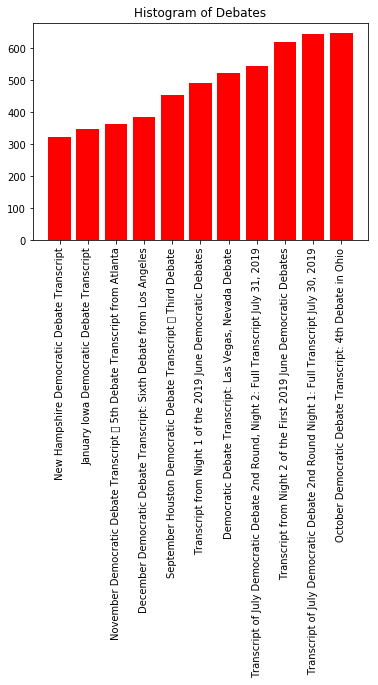

In [5]:
# Plot of debates
import matplotlib.pyplot as plt

plt.bar(list(debates.keys()), debates.values(), color='red')
plt.title("Histogram of Debates")
plt.xticks(rotation = 90)
plt.rcParams["figure.figsize"] = (10,10)

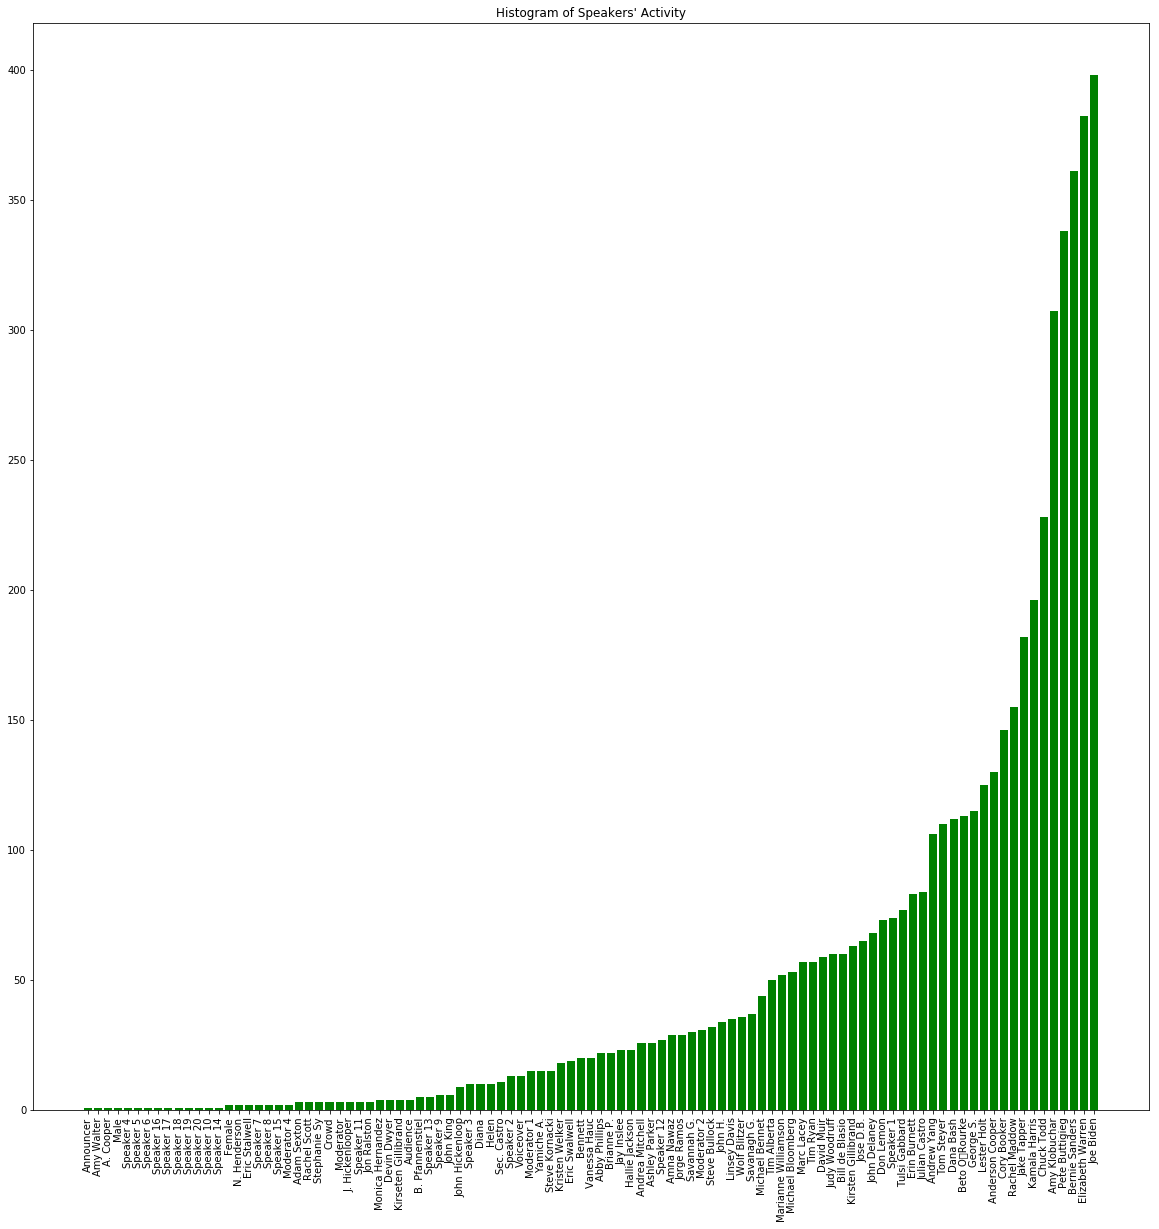

In [77]:
# Plot of speakers' activity
plt.bar(list(speakers.keys()), speakers.values(), color='green')
plt.title("Histogram of Speakers' Activity")
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"] = (20,20)

## Topic Modeling with Latent Dirichlet Allocation

In [40]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
random_state = 0

# Taking into consideration only nouns so as to identify the topics.
def only_nouns(texts):
    output = []
    for doc in nlp.pipe(texts):
        noun_text = " ".join(token.lemma_ for token in doc if token.pos_ == 'NOUN')
        output.append(noun_text)
    return output

In [63]:
# Merging the nouns-only list to the dataset.
data_new = only_nouns(data["speech"])
speech_nouns = pd.DataFrame(data_new)
data["Index"] = data.index
speech_nouns["Index"] = speech_nouns.index
democrat_data = pd.merge(data, speech_nouns, on="Index")
democrat_data.columns = ["debate_name", "debate_section", "speaker", "speech", "speaking_time_seconds", "index", "speech_nouns"]
democrat_data = democrat_data.drop(["index"], axis=1)
democrat_data.head()

,debate_name,debate_section,speaker,speech,speaking_time_seconds,speech_nouns
0,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Candidates, welcome. Vice President Biden, the...",18.0,candidate question day risk top risk
1,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Oh, they didnt miss anything. Its a long rac...",36.0,race hit hit point time neighboring senator re...
2,New Hampshire Democratic Debate Transcript,Part 1,George S.,Why are Senator Sanders and Mayor Buttigieg to...,4.0,risk
3,New Hampshire Democratic Debate Transcript,Part 1,Joe Biden,"Well, you know that with regard to Senator San...",41.0,regard label candidate time socialist label no...
4,New Hampshire Democratic Debate Transcript,Part 1,George S.,"Senator Sanders, let me give you the chance to...",21.0,chance label socialism nation socialism honeym...


In [73]:
# Number of topics to extract
n_topics = 10

# Vectorization of the nouns.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(max_features=5000, stop_words="english", max_df=0.95, min_df=2)
features = vec.fit_transform(democrat_data.speech_nouns)

# Non-negative matrix factorization.
from sklearn.decomposition import NMF
cls = NMF(n_components=n_topics, random_state=random_state)
cls.fit(features)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=10, random_state=0, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [74]:
# List of unique words
feature_names = vec.get_feature_names()

# Number of top words per topic
n_top_words = 20

for i, topic_vec in enumerate(cls.components_):
    print(i, end=' ')
    for fid in topic_vec.argsort()[-1:-n_top_words-1:-1]:
        print(feature_names[fid], end=' ')
    print()

0 response congressman sir justice congresswoman buyback chance idea stage candidate discussion wealth colleague senator state secretary sponsor person guarantee tax 
1 people law lot election government party drug million campaign help healthcare reason community prescription corporation justice life class cost choice 
2 second closing candidate floor statement sir minute followup clarification rule tonight breakdown day line night energy rebuttal debate moderator audience 
3 crosstalk lot option minute thing chance let policy tonight courage rule beginning bait candidate citizen respond allegation moment advocate crisis 
4 time candidate break statement minute moment debate chance closing fact action point district justice lot rule campaign guy sir matter 
5 question candidate debate voter tonight stage answer night break right audience word campaign lot race minute viewer economy threat deportation 
6 president vice day impeachment war law thing office congressman stage decision pre

## Highlights of the Democratic debates 2020:

1. Joe Biden and Elizabeth Warren gave more speeches that every other congressmen/congresswomen
2. All the candidates spoke for an average duration of 17 seconds.
3. The most common topics of discussion were: 
                         (1) Wealth and tax returns of the candidates
                         (2) Healthcare provisions for the community
                         (3) Follow-up, opening, closing, and rebuttals 
                         (4) Changes in policies, and the associated dilemmas
                         (5) Judiciary, and law
                         (6) Deportation issues, and the economic impacts
                         (7) Impeachment of the President
                         (8) Climate change
                         (9) Various classes in the society (higher, lower, and middle) and respective issues
                         (10) Gun laws, and racism
                         
The analysis of the democratic debates show that the debates generally center around the wealth status of the candidates and the respective follow-ups/rebuttals/rivalries. The second most prioritized topic is "Healthcare", which is a prime concern for people of all demographics. The ethical dilemmas within the conducts of the American society are less discussed, due to possible lobbying efforts and differing points of view (when the party members know certain topics are too controversial, they tend to not mention it voluntarily in their speeches, but it seems they are asked questions regarding those topics by other members/audience).

## Sentiment clarification with Word2Vec Embedding

In [89]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

democrat_speeches = list()
lines = data["speech"].tolist()

for line in lines:
    tokens = word_tokenize(line)
    # lowercase
    tokens = [word.lower() for word in tokens]
    # remove punctuation
    table = str.maketrans("","", string.punctuation)
    strip = [w.translate(table) for w in tokens]
    # remove remaining non-alphabets
    words = [word for word in strip if word.isalpha()]
    # filter stop-words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    democrat_speeches.append(words)

5333


In [94]:
import gensim

# Train word2vec model
model = gensim.models.Word2Vec(sentences = democrat_speeches, size = 100, window = 5, workers = 4, min_count = 1)
# Vocab size
words = list(model.wv.vocab)
print("Vocabulary size: ", len(words))

Vocabulary size:  8824


In [105]:
print("Talked issue #1: Tax")
model.wv.most_similar("tax")

Talked issue #1: Tax


[('income', 0.9997667074203491),
 ('away', 0.9997614622116089),
 ('family', 0.9997472763061523),
 ('children', 0.9997379183769226),
 ('kids', 0.9997144937515259),
 ('afford', 0.999687135219574),
 ('create', 0.9996702075004578),
 ('paid', 0.999662458896637),
 ('wealthy', 0.9996582269668579),
 ('education', 0.999648928642273)]

In [106]:
print("Talked issue #2: Healthcare")
model.wv.most_similar("healthcare")

Talked issue #2: Healthcare


[('people', 0.9978628158569336),
 ('insurance', 0.9974043369293213),
 ('million', 0.9973002672195435),
 ('health', 0.9969488382339478),
 ('longterm', 0.9969123005867004),
 ('working', 0.9965479373931885),
 ('companies', 0.9963619112968445),
 ('single', 0.9963474273681641),
 ('work', 0.9962557554244995),
 ('care', 0.9957213401794434)]

In [107]:
print("Talked issue #3: Rebuttals")
model.wv.most_similar("rebuttal")

Talked issue #3: Rebuttals


[('ms', 0.98667311668396),
 ('bernie', 0.9854209423065186),
 ('much', 0.9853670001029968),
 ('ank', 0.9852139949798584),
 ('final', 0.9850896596908569),
 ('swalwell', 0.9841780662536621),
 ('mrs', 0.9836959838867188),
 ('said', 0.983674168586731),
 ('minute', 0.9835032820701599),
 ('sir', 0.983461320400238)]

In [108]:
print("Talked issue #4: Policy")
model.wv.most_similar("policy")

Talked issue #4: Policy


[('stop', 0.9997724294662476),
 ('nuclear', 0.9997251033782959),
 ('without', 0.9997192025184631),
 ('brought', 0.9997175931930542),
 ('border', 0.99970942735672),
 ('kind', 0.9997011423110962),
 ('industrial', 0.999698281288147),
 ('accountable', 0.9996978640556335),
 ('actually', 0.9996954202651978),
 ('civil', 0.9996945261955261)]

In [112]:
print("Talked issue #5: Law")
model.wv.most_similar("law")

Talked issue #5: Law


[('anything', 0.9998910427093506),
 ('responsibility', 0.9998449087142944),
 ('tried', 0.9998339414596558),
 ('leader', 0.9998326301574707),
 ('nothing', 0.9998283386230469),
 ('ever', 0.9997944235801697),
 ('national', 0.9997861385345459),
 ('lead', 0.999774694442749),
 ('still', 0.9997681379318237),
 ('understand', 0.9997668266296387)]

In [113]:
print("Talked issue #6: Immigration")
model.wv.most_similar("immigration")

Talked issue #6: Immigration


[('important', 0.9998724460601807),
 ('talked', 0.9998362064361572),
 ('reason', 0.9998355507850647),
 ('long', 0.9998096227645874),
 ('kind', 0.9998048543930054),
 ('different', 0.9998037815093994),
 ('power', 0.9997957944869995),
 ('shot', 0.9997879266738892),
 ('nuclear', 0.9997877478599548),
 ('allies', 0.999783992767334)]

In [114]:
print("Talked issue #7: Impeachment")
model.wv.most_similar("impeachment")

Talked issue #5: Impeachment


[('wrong', 0.9998272061347961),
 ('mitch', 0.9997649192810059),
 ('continue', 0.9997590184211731),
 ('mcconnell', 0.9997272491455078),
 ('likely', 0.9997154474258423),
 ('name', 0.9996985197067261),
 ('move', 0.999694287776947),
 ('would', 0.9996904730796814),
 ('son', 0.9996898174285889),
 ('chief', 0.9996853470802307)]

In [115]:
print("Talked issue #8: Climate")
model.wv.most_similar("climate")

Talked issue #8: Climate


[('need', 0.9976078271865845),
 ('work', 0.9966866970062256),
 ('country', 0.9966683387756348),
 ('things', 0.9964683055877686),
 ('making', 0.9960207939147949),
 ('american', 0.9958280920982361),
 ('together', 0.9957555532455444),
 ('working', 0.995715320110321),
 ('million', 0.9955306053161621),
 ('jobs', 0.9954936504364014)]

In [116]:
print("Talked issue #9: Class")
model.wv.most_similar("class")

Talked issue #9: Class


[('pay', 0.999352753162384),
 ('families', 0.9990930557250977),
 ('uninsured', 0.9989917278289795),
 ('care', 0.9989700317382812),
 ('american', 0.9989570379257202),
 ('jobs', 0.9986506104469299),
 ('making', 0.9986433982849121),
 ('system', 0.9986083507537842),
 ('costs', 0.9985483884811401),
 ('work', 0.9984985589981079)]

In [117]:
print("Talked issue #10: Racism")
model.wv.most_similar("racism")

Talked issue #10: Racism


[('somebody', 0.9998521208763123),
 ('business', 0.9998329877853394),
 ('politics', 0.9998295903205872),
 ('longer', 0.999826967716217),
 ('brought', 0.9998248815536499),
 ('comes', 0.9998179078102112),
 ('industrial', 0.9998133182525635),
 ('ban', 0.9998074173927307),
 ('leaders', 0.9998073577880859),
 ('always', 0.9998027682304382)]